In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from string import punctuation 

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
import re 

for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
import warnings
warnings.filterwarnings("ignore")
np.random.seed(43)

import joblib 

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
file_name = "../DATA/data.csv"
reviews = pd.read_csv(file_name)
reviews.head()

,comentario,calificacion
0,Muy buena aplicacion,5
1,"Que servicio tan malo, intento comunicarme con...",1
2,Excelente Servicio muy bien muchas gracias,5
3,Desde la actualización realizada el 28-07-2021...,1
4,Si lleva más de una semana mala la señal no se...,1


### Exploracion de los datos

In [10]:
reviews['calificacion'].value_counts()

5    45059
1    24023
4     8469
3     4796
2     4493
Name: calificacion, dtype: int64

<Figure size 800x960 with 0 Axes>

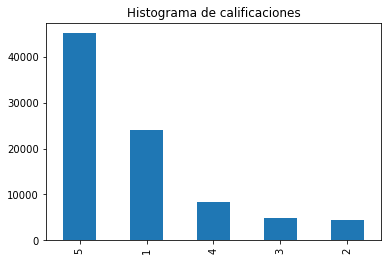

<Figure size 800x960 with 0 Axes>

In [48]:
reviews['calificacion'].value_counts().plot(kind='bar')
plt.title('Histograma de calificaciones')
plt.figure(figsize=(10, 12), dpi=80)

In [20]:
length_review = []
for x in range(reviews.shape[0]): length_review.append(len(reviews.iloc[x]['comentario']))

<Figure size 1200x1000 with 0 Axes>

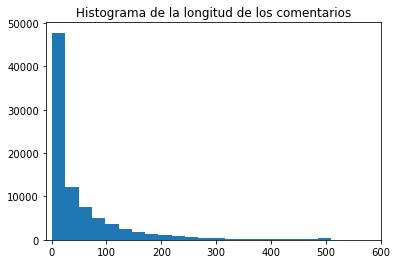

<Figure size 1200x1000 with 0 Axes>

In [53]:
bins = np.linspace(math.ceil(min(length_review)), 
                   math.floor(max(length_review)),
                   50) 

plt.xlim([-10, 600])
plt.hist(length_review, bins=bins, alpha=1)
plt.title('Histograma de la longitud de los comentarios')
plt.figure(figsize=(12, 10), dpi=100)

# Entrenamiento de modelos

## Modelo para determinar la connotación de los comentarios

Para obtener las connotaciones de las opinionbes se hizo uso de las calificaciones en donde una calificacion de 4 y 5 estrellas se considera positiva (1). de 1 y 2 estrellas se considera negativa (-1) y de 3 se considera neutra (0).

In [130]:
def generar_connotacion_en_base_a_calificacion(calificacion):
    
    if calificacion >= 4:
        return 1
    elif calificacion <= 2:
        return -1
    else:
        return 0

In [131]:
reviews['connotacion'] = reviews['calificacion'].apply(lambda x: generar_connotacion_en_base_a_calificacion(x))

In [132]:
reviews.head()

,comentario,calificacion,connotacion,comentario_limpiado
0,Muy buena aplicacion,5,1,"[buen, aplicacion]"
1,"Que servicio tan malo, intento comunicarme con...",1,-1,"[servici, tan, mal, intent, comunic, usted, fo..."
2,Excelente Servicio muy bien muchas gracias,5,1,"[excelent, servici, bien, much, graci]"
3,Desde la actualización realizada el 28-07-2021...,1,-1,"[actualiz, realiz, sal, mensaj, pued, conect, ..."
4,Si lleva más de una semana mala la señal no se...,1,-1,"[si, llev, seman, mal, señal, pued, llam, enti..."


## Preprocesamiento de los comentarios

In [120]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
def limpiado_de_texto(texto, remove_stop_words=True, stemming_words=True):
    
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # remover numeros
    texto = re.sub(r'\b\d+(?:\.\d+)?\s+', '', texto) 
    # Convertimos textos a minusculas
    texto = texto.lower()
    
    # Tokenizado
    tokenizer = ToktokTokenizer() 
    tokens = tokenizer.tokenize(texto)
    
    # Eliminacion de stopwords
    stop_words =  stopwords.words('spanish')
    if remove_stop_words:
        tokens = [w for w in tokens if not w in stop_words]

    # Stemming
    stemmer = SnowballStemmer("spanish") 
    if stemming_words:
        tokens = [stemmer.stem(token) for token in tokens]
    
    text = " ".join(tokens)
 
    return(text)

In [145]:
reviews.iloc[3]['comentario']

'Desde la actualización realizada el 28-07-2021 me sale un mensaje que no se puede conectar a la red, ni con wi-fi ni con los datos, no he podido ver mis consumos o pagar desde la app, por favor dar solución y sacar la corrección del error'

In [146]:
limpiado_de_texto(reviews.iloc[3]['comentario'])

'actualiz realiz sal mensaj pued conect red wi fi dat pod ver consum pag app favor dar solucion sac correccion error'

In [147]:
reviews['comentario_limpiado'] = reviews['comentario'].apply(lambda x: limpiado_de_texto(x))

In [148]:
reviews.head()

,comentario,calificacion,connotacion,comentario_limpiado
0,Muy buena aplicacion,5,1,buen aplicacion
1,"Que servicio tan malo, intento comunicarme con...",1,-1,servici tan mal intent comunic usted form escr...
2,Excelente Servicio muy bien muchas gracias,5,1,excelent servici bien much graci
3,Desde la actualización realizada el 28-07-2021...,1,-1,actualiz realiz sal mensaj pued conect red wi ...
4,Si lleva más de una semana mala la señal no se...,1,-1,si llev seman mal señal pued llam entiend


### Entrenamiento del modelo

In [164]:
X = reviews["comentario_limpiado"]
y = reviews.connotacion.values

In [165]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

In [166]:
sentiment_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes',MultinomialNB())
                                 ])

In [167]:
sentiment_classifier.fit(X_train,y_train)

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('naive_bayes', MultinomialNB())])

In [168]:
y_preds = sentiment_classifier.predict(X_valid)

#### Resultados del modelo

In [169]:
accuracy_score(y_valid,y_preds)

0.8819284507907262

In [182]:
precision_score(y_valid,y_preds, average='weighted')

0.8379944126335224

In [183]:
recall_score(y_valid,y_preds, average='weighted')

0.8819284507907262

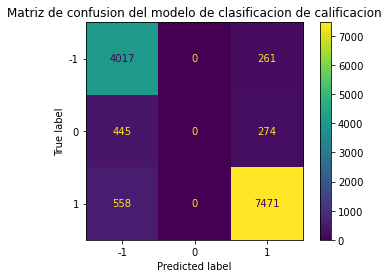

In [212]:
plot_confusion_matrix(sentiment_classifier, X_valid, y_valid)  
plt.title('Matriz de confusion del modelo de clasificacion de calificacion')
plt.show() 

#### Guadado del modelo

In [174]:
joblib.dump(sentiment_classifier, '../models/sentiment_model.pkl')

['../models/sentiment_model.pkl']

## Modelo para predecir la calificacion de los comentarios

In [195]:
X_1 = reviews["comentario_limpiado"]
y_1 = reviews.calificacion.values

In [196]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1,
    y_1,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

In [197]:
calification_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes',MultinomialNB())
                                 ])

In [198]:
calification_classifier.fit(X_train_1,y_train_1)

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('naive_bayes', MultinomialNB())])

In [204]:
y_preds_1 = calification_classifier.predict(X_valid_1)

#### Resultados del modelo

In [205]:
accuracy_score(y_valid_1,y_preds_1)

0.7557193305696299

In [206]:
precision_score(y_valid_1,y_preds_1, average='weighted')

0.6663224355499393

In [207]:
recall_score(y_valid_1,y_preds_1, average='weighted')

0.7557193305696299

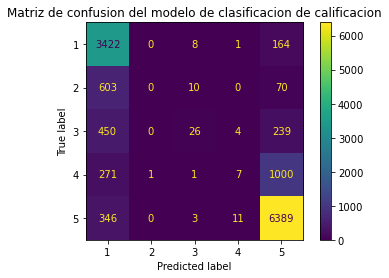

In [210]:
plot_confusion_matrix(calification_classifier, X_valid_1, y_valid_1)  
plt.title('Matriz de confusion del modelo de clasificacion de calificacion')
plt.show() 

#### Guadado del modelo

In [211]:
joblib.dump(calification_classifier, '../models/calification_model.pkl')

['../models/calification_model.pkl']